# Capstone: Sephora. Predicting prices based on Ingredients

## Problem description

It is an assumption customers make that their skin care product price is dependent on the ingredients in this product. The goal of my projects is to see if I can predict prices of the products based on the ingredients. To accomplish this goal, I first had to gather my data. I used Sephora.com data for this.

### Project Structure:
- Notebook 0. Selenium URL Collection
- Notebook 1. Saving data from URL to an HTML file
- Notebook 2. Collecting Product Data
- Notebook 3. Data Cleaning 
- Notebook 4. EDA
- Notebook 5. Fuzzy String Matching
- Notebook 6. Regression Modeling
- Notebook 7. Classification Modeling

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score

In [2]:
products = pd.read_csv('./data/products_fuzzywuzzy.csv')
products.head(2)

,name,brand,category,price,ingredients,no_reviews,hearts,size1,size2,url,final_size,price_per_ounce
0,Protini™ Polypeptide Moisturizer,Drunk Elephant,moisturizing-cream-oils-mists,68.0,"Dicaprylyl Carbonate, Glycerin, Cetearyl Alcoh...",3000,216935,1.69,0.0,https://www.sephora.com/product/protini-tm-pol...,1.69,40.236686
1,The Water Cream,Tatcha,moisturizing-cream-oils-mists,68.0,"Dicaprylyl Carbonate, Glycerin, Cetearyl Alcoh...",2000,197492,0.00,1.7,https://www.sephora.com/product/the-water-crea...,1.70,40.000000


In [3]:
X = products['ingredients'] #setting our X variable

y = np.log(products['price_per_ounce']) #our y variable is price_per_ounce

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,  test_size=.33)

In [4]:
baseline_preds = [y.mean()]*2457

In [5]:
r2_score(y, baseline_preds)

0.0

In [6]:
np.sqrt(mean_squared_error(y, baseline_preds))

1.244453174700428

## Raw Model

My idea initially was to run raw models to gain a sense of direction to go and then tune the models to gain the best result possible. However no amount of tuning made any significant improvement to any of the models. I implemented Tfidf Vectorizer inplace of the CountVectorizer, used Pipelines and GridSearch on every model and the best improvement was a 0.02 increase in test R_squared for the SVR model. I used these tuning params when I later implemented an ensemble of using brand and category with ingredients to make a prediction. The only significant change came from taking the logarithm of my y-variable. You see from the picture below what the results were initially before the logarithm. Compary them to the results after running the models again.  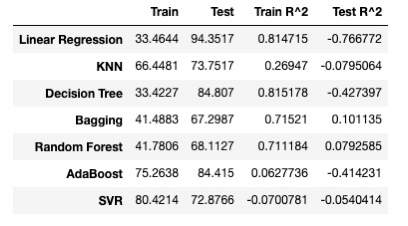

In [7]:
#CountVactorizer splits the ingredients by comma and not in to individual words
cvec = CountVectorizer(tokenizer=lambda x: x.split(', '))
#training CountVectorizer and transforming
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

,Train,Test,Train R^2,Test R^2
Linear Regression,0.422411,1.3084,0.886691,-0.146155
KNN,0.96821,1.15307,0.404706,0.10984
Decision Tree,0.422219,1.22208,0.886795,8.5947e-05
Bagging,0.549183,1.03124,0.808475,0.287998
Random Forest,0.547265,1.01412,0.80981,0.311443
AdaBoost,1.18259,1.15915,0.111901,0.100422
SVR,0.685412,0.962627,0.70167,0.379594


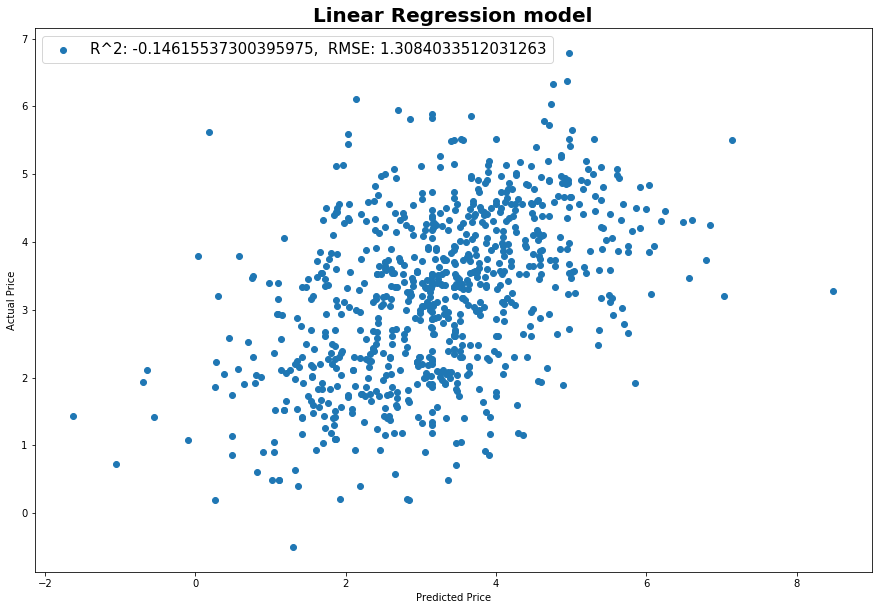

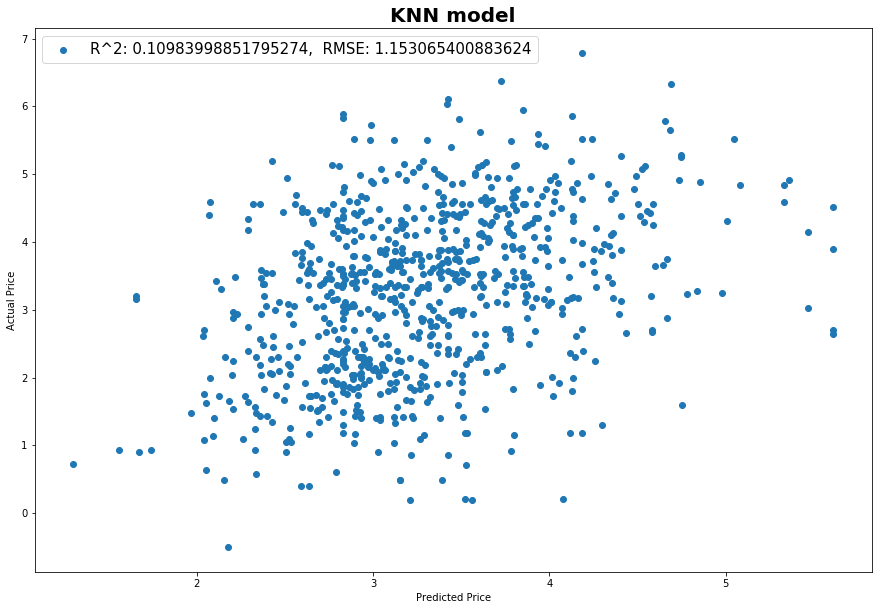

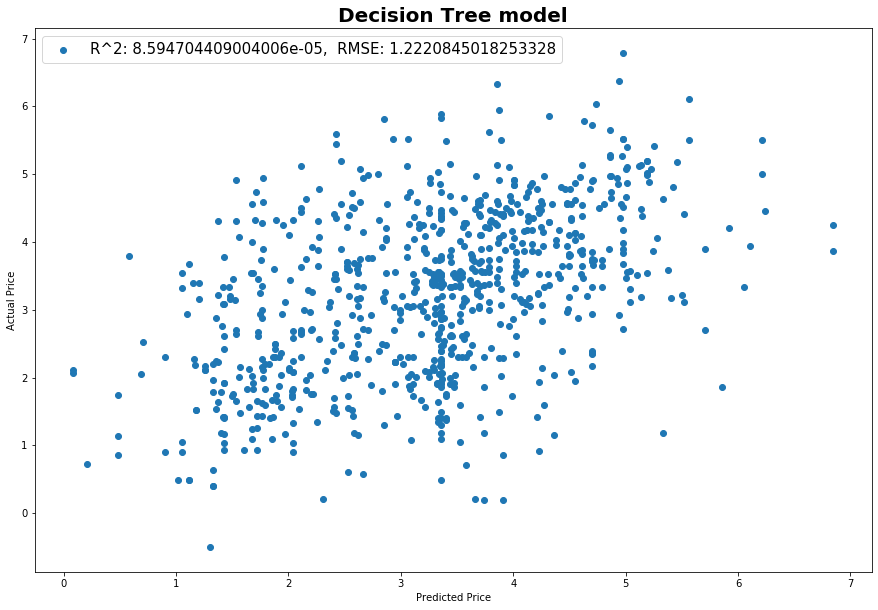

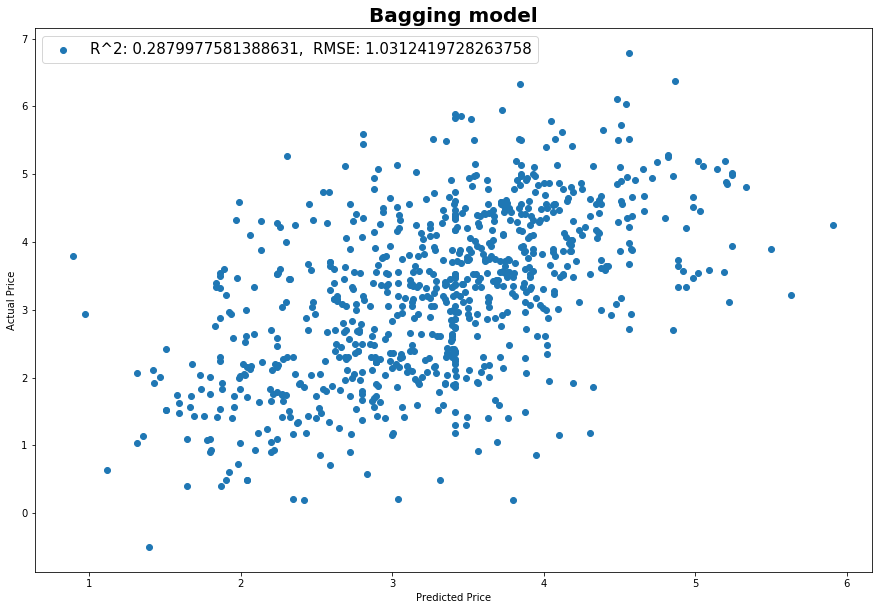

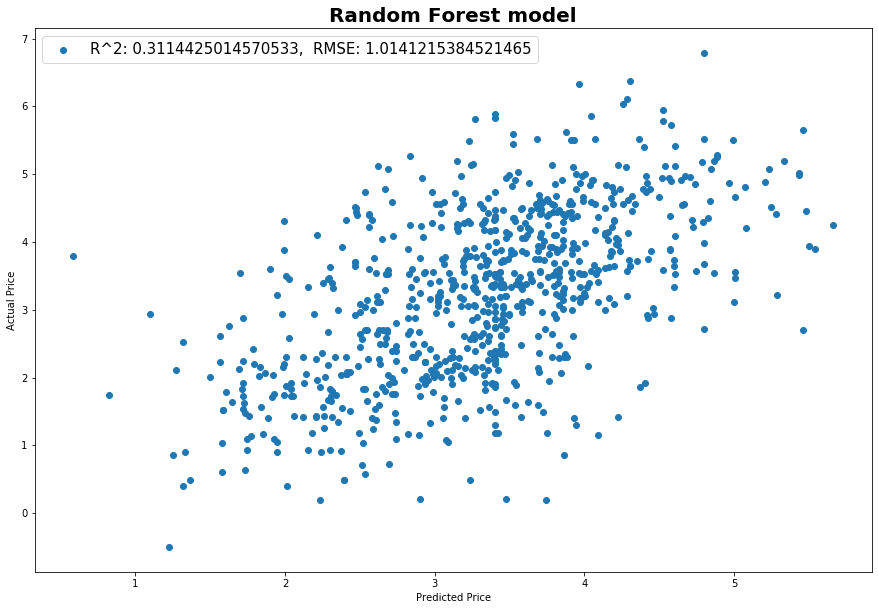

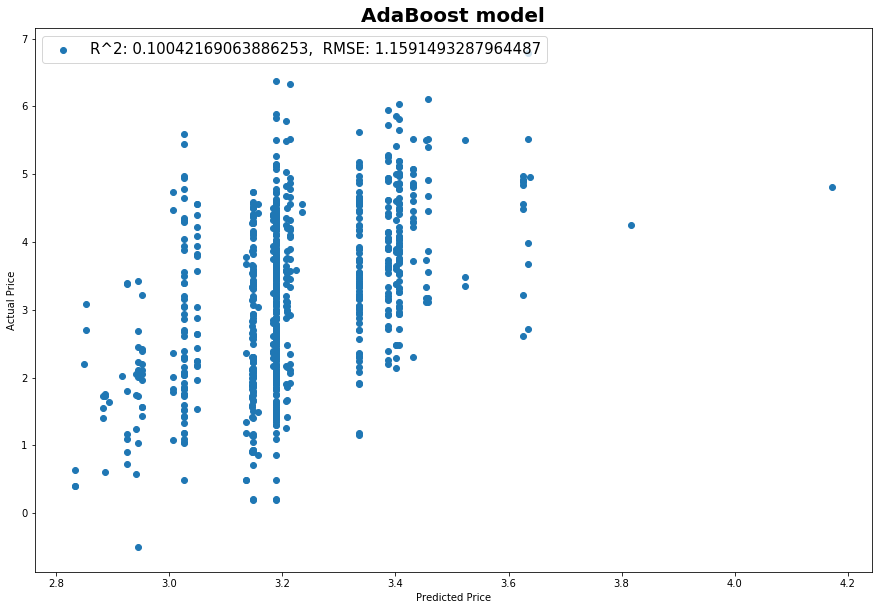

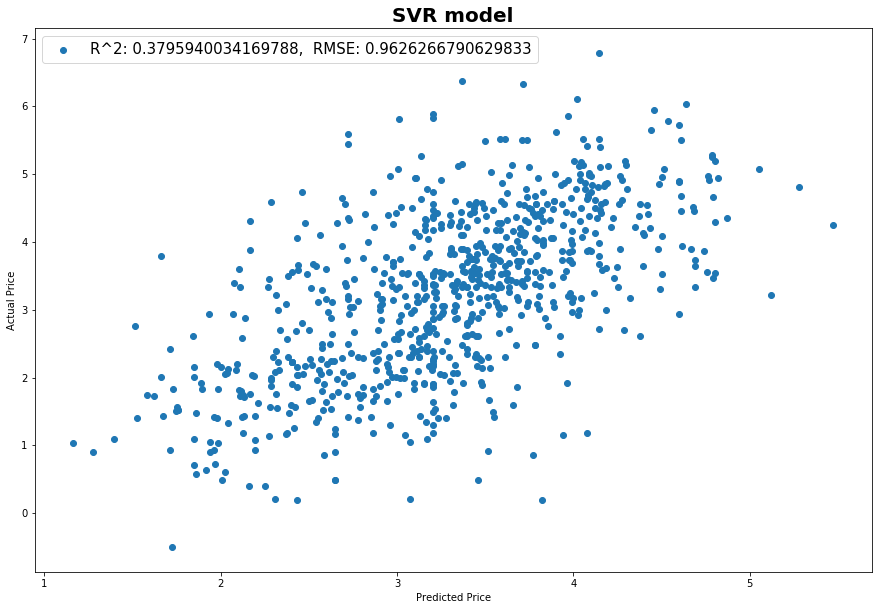

In [8]:
#instantiating models
lr = LinearRegression()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor(random_state=42)
bdt = BaggingRegressor(random_state=42)
rf = RandomForestRegressor(n_estimators = 10)
abr = AdaBoostRegressor(random_state = 42)
svr = SVR(gamma = 'scale')

models = {
    'Linear Regression': lr,
    'KNN': knn, 
    'Decision Tree': dt, 
    'Bagging': bdt, 
    'Random Forest': rf, 
    'AdaBoost': abr,
    'SVR': svr
}
#list of model names
model_names = ['Linear Regression', 'KNN', 'Decision Tree', 'Bagging', 'Random Forest', 'AdaBoost', 'SVR']
#creating a data frame that rmse scores will go in to
rmse_all_cvec = pd.DataFrame(index = model_names, columns = ['Train', 'Test', 'Train R^2', 'Test R^2'])
#fitting the models and calculating their rmse
for x in models:
    models[x].fit(X_train_cvec, y_train) #fitting the model
    y_train_preds = models[x].predict(X_train_cvec) #prediction for train
    y_test_preds = models[x].predict(X_test_cvec) #prediction for test
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_preds)) #rmse for train
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_preds)) #rmse for test
    rmse_all_cvec.loc[x, 'Train'] = rmse_train #updating the dataframe
    rmse_all_cvec.loc[x, 'Test'] = rmse_test
    rmse_all_cvec.loc[x, 'Train R^2'] = models[x].score(X_train_cvec, y_train)
    rmse_all_cvec.loc[x, 'Test R^2'] = models[x].score(X_test_cvec, y_test)
    
    plt.figure(figsize = (15,10))
    plt.scatter(y_test_preds, y_test)

    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('{} model'.format(x), weight='bold', fontsize=20);
    plt.legend(['R^2: {},  RMSE: {}'.format(models[x].score(X_test_cvec, y_test), rmse_test)], loc = 'upper left', fontsize = 15);
    
    
    
rmse_all_cvec

## Brand and Category

Since, it seemed that my hope of predicting the price based on the product's ingredients seemed to not be working out well for me, I wanted to see what results I can get by using the brand and the category of the product. You can see that with just Linear Regression my results were significantly better. I actually run all the models as above. However, the results didn't go up from Linear Regression. 

In [9]:
X = products[['brand', 'category']]
y = np.log(products['price_per_ounce'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,  test_size=.33)

In [10]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X)
X_train = ohe.transform(X_train)
X_test = ohe.transform(X_test)

In [11]:
#instantiating models
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.7770518875853512

In [12]:
lr.score(X_test, y_test)

0.7271361260564448

In [13]:
y_test_preds = lr.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_test_preds))

0.6384000624386822

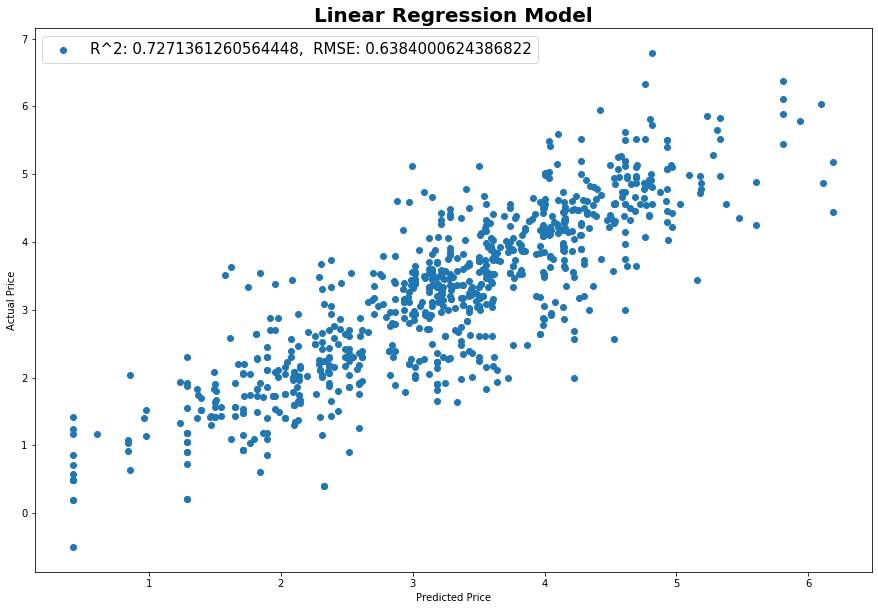

In [14]:
r_squared = lr.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_test_preds))

plt.figure(figsize = (15,10))
plt.scatter(y_test_preds, y_test)

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model', weight='bold', fontsize=20);
plt.legend(['R^2: {},  RMSE: {}'.format(r_squared, rmse)], loc = 'upper left', fontsize = 15);


## Brand, Category and Ingredients

Since I had success with brand and category, I wanted to see what kind of output I would get with using all three. My results were much more promissing than with just ingredients. However they were slightly below just using the brand and category. 

In [15]:
#https://www.toptal.com/machine-learning/ensemble-methods-machine-learning
#making sure we run the same train test split for comparison
X = products[['brand', 'category','ingredients']]

y = np.log(products['price_per_ounce'])

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,  test_size=.33)

In [16]:
#transform the ingredients columns
tfidf = TfidfVectorizer(tokenizer=lambda x: x.split(', '))
X_train_tfidf = tfidf.fit_transform(X_train['ingredients'])
X_test_tfidf = tfidf.transform(X_test['ingredients'])

#transform the brand and category column
ohe = OneHotEncoder(handle_unknown='ignore')
X_train_ohe = ohe.fit_transform(X_train[['brand', 'category']])
X_test_ohe = ohe.transform(X_test[['brand', 'category']])

In [17]:
#make predictions for the ingredients
svr = SVR(gamma = 'scale', C = 0.722, kernel = 'linear')
svr.fit(X_train_tfidf, y_train)
y_preds_ing = svr.predict(X_test_tfidf)

#make predictions for the brand and category
lr = LinearRegression()
lr.fit(X_train_ohe, y_train)
y_pred_brand = lr.predict(X_test_ohe)

In [18]:
#i have the weights set up cuz i played around with multiple. but the model withough weights did the best
weight_ing = 1
weight_brand = 1
y_preds_ing_w = y_preds_ing * weight_ing
y_pred_brand_w = y_pred_brand * weight_brand
final_predictions = []
for i in range(len(y_preds_ing_w)):
    final_predictions.append(np.average([y_preds_ing_w[i], y_pred_brand_w[i]]))

In [19]:
r_squared = r2_score(y_test, final_predictions)

In [20]:
rmse = np.sqrt(mean_squared_error(y_test, final_predictions))

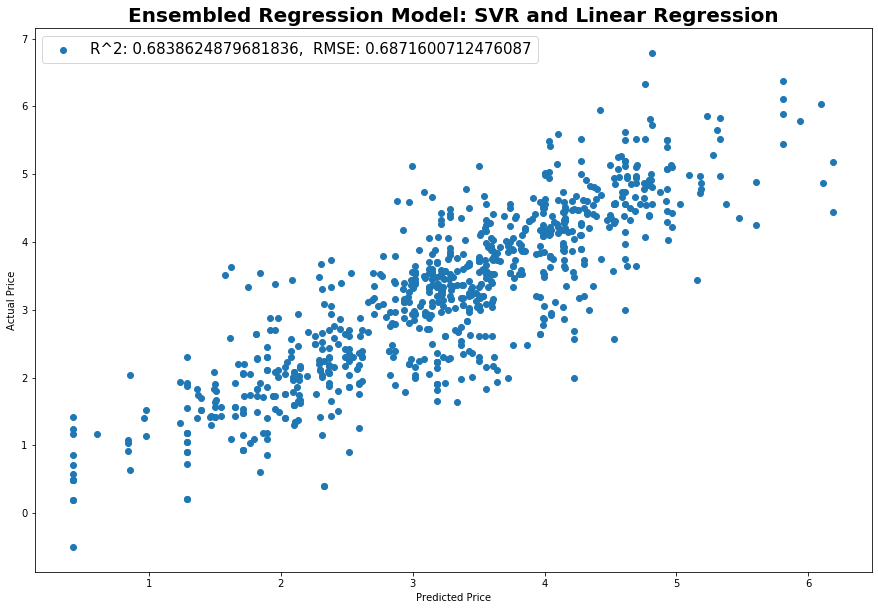

In [21]:
plt.figure(figsize = (15,10))
plt.scatter(y_test_preds, y_test)

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Ensembled Regression Model: SVR and Linear Regression', weight='bold', fontsize=20);
plt.legend(['R^2: {},  RMSE: {}'.format(r_squared, rmse)], loc = 'upper left', fontsize = 15);